# Logo Detection Using PyTorch for Colab

#  Colab Preparation

## Install PyTorch 0.4 for Colab

In [1]:
!pip install wheel setuptools
!python -m pip install pycparser
!pip3 install wheel==0.34.1

  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl 
!pip3 install torchvision

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.0 from http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl


In [3]:
import torch
print(torch.__version__)
print(accelerator)
print(torch.cuda.is_available())

1.10.0+cu111
cu80
True


# 1. Get the Data

In [4]:
import urllib.request
import os
import zipfile
import shutil
from pathlib import Path

In [8]:
# See download section on URL: http://www.multimedia-computing.de/flickrlogos/
FLICKLOGOS_URL = "http://bit.ly/FlickrLogos32v2"

In [9]:
SOURCE_DIR = Path('FlickrLogos-v2')
DATA_DIR = Path('data')
SETS = ['train', 'val', 'test']

In [10]:
def load_datasets(url, dst_dir):
    zip_file = url.split(sep='/')[-1]
    zip_file_path = SOURCE_DIR / zip_file
    if not dst_dir.is_dir():
        if not zip_file_path.is_file():
            urllib.request.urlretrieve(url, zip_file)        
        with zipfile.ZipFile(zip_file) as zip_ref:
            zip_ref.extractall()
        #os.unlink(zip_file)    # comment out if you want to delete zip file

In [11]:
%time load_datasets(FLICKLOGOS_URL, SOURCE_DIR)

CPU times: user 31.3 s, sys: 15.3 s, total: 46.6 s
Wall time: 3min 30s


In [12]:
!ls FlickrLogos-v2

all.filenames.txt		 trainset.relpaths.txt
all.relpaths.txt		 trainset.spaces.txt
all.spaces.txt			 trainset.txt
all.txt				 trainvalset.filenames.txt
classes				 trainvalset.relpaths.txt
README.txt			 trainvalset.spaces.txt
scripts				 trainvalset.txt
testset.filenames.txt		 valset.filenames.txt
testset-logosonly.filenames.txt  valset-logosonly.filenames.txt
testset-logosonly.relpaths.txt	 valset-logosonly.relpaths.txt
testset-logosonly.spaces.txt	 valset-logosonly.spaces.txt
testset-logosonly.txt		 valset-nologos.filenames.txt
testset-nologos.filenames.txt	 valset-nologos.relpaths.txt
testset-nologos.relpaths.txt	 valset-nologos.spaces.txt
testset-nologos.spaces.txt	 valset.relpaths.txt
testset.relpaths.txt		 valset.spaces.txt
testset.spaces.txt		 valset.txt
testset.txt			 visualsummary.jpg
trainset.filenames.txt


# 2. Prepare Datasets

In [13]:
def list_image_paths(txt_relpath):
    with open(txt_relpath) as f:
        image_paths = f.read().splitlines()
    return image_paths

In [14]:
train_logo_relpaths = list_image_paths(SOURCE_DIR / 'trainset.relpaths.txt')
val_logo_relpaths = list_image_paths(SOURCE_DIR / 'valset-logosonly.relpaths.txt')
val_nologo_relpaths = list_image_paths(SOURCE_DIR / 'valset-nologos.relpaths.txt')
test_relpaths = list_image_paths(SOURCE_DIR / 'testset.relpaths.txt')

In [15]:
print('Numbers of Training Images (logo): ',len(train_logo_relpaths))
print('Numbers of Validation Images (logo): ',len(val_logo_relpaths))
print('Numbers of Training Images (no logo): ',len(val_nologo_relpaths))
print('Numbers of Test Images (logos + no log): ',len(test_relpaths))

Numbers of Training Images (logo):  320
Numbers of Validation Images (logo):  960
Numbers of Training Images (no logo):  3000
Numbers of Test Images (logos + no log):  3960


In [16]:
train_relpaths = train_logo_relpaths + val_nologo_relpaths[:int(len(val_nologo_relpaths) / 2)]
val_relpaths = val_logo_relpaths + val_nologo_relpaths[int(len(val_nologo_relpaths) / 2):]

In [17]:
print('Numbers of Training Images (logos + no logo): ',len(train_relpaths))
print('Numbers of Validation Images (logos + no logo): ',len(val_relpaths))
print('Numbers of Training Images (logos + no log): ',len(test_relpaths))

Numbers of Training Images (logos + no logo):  1820
Numbers of Validation Images (logos + no logo):  2460
Numbers of Training Images (logos + no log):  3960


In [18]:
relpaths = [train_relpaths, val_relpaths, test_relpaths]
dataset_paths = dict(zip(SETS, relpaths))
# dataset_paths = dict(train=train_relpaths, val=val_relpaths, test=test_relpaths)

In [19]:
len(dataset_paths['train'])

1820

In [20]:
train_logo_relpaths[0]

'classes/jpg/google/2325670467.jpg'

In [21]:
def prepare_datasets(src_dir, dst_dir, keep_source=True):
    for dataset, paths in dataset_paths.items():
        num_files = 0
        for path in paths:
            num_files += 1
            src = src_dir / path
            dst = dst_dir / (path.replace('classes/jpg', dataset))
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
        print(dataset, 'dataset:', str(num_files))
    if not keep_source: shutil.rmtree(src_dir)

In [22]:
!ls data

ls: cannot access 'data': No such file or directory


In [23]:
# Run once
%time prepare_datasets(SOURCE_DIR, DATA_DIR)

train dataset: 1820
val dataset: 2460
test dataset: 3960
CPU times: user 2.46 s, sys: 5.93 s, total: 8.39 s
Wall time: 51.1 s


## DataLoader

In [24]:
%matplotlib inline
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [25]:
train_mean = np.array([0.44943, 0.4331 , 0.40244])
train_std = np.array([0.29053, 0.28417, 0.30194])

In [26]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

In [27]:
datasets = {i : torchvision.datasets.ImageFolder(DATA_DIR / i, data_transforms) 
            for i in SETS}

In [28]:
bz = 8 # lower if error

In [29]:
dataloaders = {i : DataLoader(datasets[i], batch_size=bz, shuffle=(i == 'train'), num_workers=4) 
               for i in SETS}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualize Datasets

In [30]:
def imshow(img):
    npimg = img.numpy().transpose((1, 2, 0))
    npimg = npimg * train_std + train_std    # denorm
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)

In [31]:
imgs, labels = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


no-logo, ferrari, no-logo, no-logo


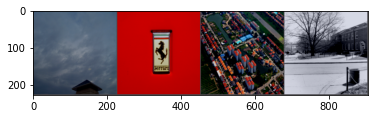

In [32]:
img = torchvision.utils.make_grid(imgs[:4])
classes = datasets['train'].classes
print(', '.join(classes[i] for i in labels[:4]))
imshow(img)

# 3Create Network

<img src="https://pytorch.org/tutorials/_images/mnist.png">

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 33)        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
cnn = CNN()
cnn = cnn.to(device)
cnn

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=33, bias=True)
)

## Define a Loss Function and Optimizer

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

## Train the Network

In [37]:
def train_val(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoc {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
            
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Compute loss
                    loss = criterion(outputs, labels)

                    # Compute gradients and update parameters if train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects / len(datasets[phase])
        
            print('{} Loss: {:.4f} Acc.: {:.2f} %'.format(
                phase.title(), epoch_loss, epoch_acc * 100))
        
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Accuracy: {:.2f} %'.format(best_acc * 100))
    model.load_state_dict(best_model_wts)
    
    return model

In [38]:
%time model_cnn = train_val(cnn, criterion, optimizer)

Epoc 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.3617 Acc.: 80.16 %
Val Loss: 2.1138 Acc.: 60.98 %

Epoc 1/24
----------
Train Loss: 1.0823 Acc.: 82.42 %
Val Loss: 1.9897 Acc.: 60.98 %

Epoc 2/24
----------
Train Loss: 1.0310 Acc.: 82.42 %
Val Loss: 2.5313 Acc.: 60.98 %

Epoc 3/24
----------
Train Loss: 0.9886 Acc.: 82.42 %
Val Loss: 2.2708 Acc.: 60.98 %

Epoc 4/24
----------
Train Loss: 0.9252 Acc.: 82.42 %
Val Loss: 2.3143 Acc.: 60.98 %

Epoc 5/24
----------
Train Loss: 0.8660 Acc.: 82.42 %
Val Loss: 2.0951 Acc.: 60.98 %

Epoc 6/24
----------
Train Loss: 0.8182 Acc.: 82.58 %
Val Loss: 2.1776 Acc.: 60.98 %

Epoc 7/24
----------
Train Loss: 0.7528 Acc.: 82.86 %
Val Loss: 2.1504 Acc.: 60.65 %

Epoc 8/24
----------
Train Loss: 0.5946 Acc.: 85.33 %
Val Loss: 2.9304 Acc.: 60.53 %

Epoc 9/24
----------
Train Loss: 0.4779 Acc.: 88.90 %
Val Loss: 3.1606 Acc.: 60.08 %

Epoc 10/24
----------
Train Loss: 0.2636 Acc.: 94.18 %
Val Loss: 4.3209 Acc.: 60.57 %

Epoc 11/24
----------
Train Loss: 0.1440 Acc.: 96.54 %
Val Loss: 3.6796 Ac

# Evaluate Network

In [39]:
def test(model):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels).item()
        
    test_acc = running_corrects / len(datasets['test'])
    print('Test Acc.: {:.2f} %'.format(test_acc * 100))

In [40]:
%time test(model_cnn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Acc.: 75.76 %
CPU times: user 3.07 s, sys: 974 ms, total: 4.05 s
Wall time: 1min 10s


# Transfer Learning

## Fine-tuning

In [41]:
train_mean = np.array([0.485, 0.456, 0.406])
train_std = np.array([0.229, 0.224, 0.225])

In [42]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

In [43]:
datasets = {i : torchvision.datasets.ImageFolder(DATA_DIR / i, data_transforms) 
            for i in SETS}

In [44]:
dataloaders = {i : DataLoader(datasets[i], batch_size=bz, shuffle=(i == 'train'), num_workers=4) 
               for i in SETS}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [45]:
imgs, labels = next(iter(dataloaders['train']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


no-logo, no-logo, ferrari, no-logo


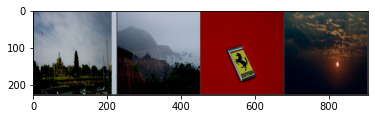

In [46]:
img = torchvision.utils.make_grid(imgs[:4])
classes = datasets['train'].classes
print(', '.join(classes[i] for i in labels[:4]))
imshow(img)

In [ ]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features                       # 512
model_ft.fc = nn.Linear(num_ftrs, 33)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

In [ ]:
%time model_ft = train_val(model_ft, criterion, optimizer_ft)

Epoc 0/24
----------
Train Loss: 0.8379 Acc.: 81.37 %
Val Loss: 1.6310 Acc.: 62.60 %

Epoc 1/24
----------
Train Loss: 0.5642 Acc.: 85.60 %
Val Loss: 1.4712 Acc.: 66.54 %

Epoc 2/24
----------
Train Loss: 0.4068 Acc.: 91.37 %
Val Loss: 1.2385 Acc.: 71.59 %

Epoc 3/24
----------
Train Loss: 0.2612 Acc.: 94.73 %
Val Loss: 1.1371 Acc.: 74.96 %

Epoc 4/24
----------
Train Loss: 0.1423 Acc.: 98.13 %
Val Loss: 1.1393 Acc.: 75.57 %

Epoc 5/24
----------
Train Loss: 0.0858 Acc.: 99.07 %
Val Loss: 1.1419 Acc.: 75.93 %

Epoc 6/24
----------
Train Loss: 0.0470 Acc.: 99.95 %
Val Loss: 1.1337 Acc.: 76.71 %

Epoc 7/24
----------
Train Loss: 0.0335 Acc.: 99.89 %
Val Loss: 1.0323 Acc.: 78.01 %

Epoc 8/24
----------
Train Loss: 0.0252 Acc.: 99.89 %
Val Loss: 1.0919 Acc.: 77.97 %

Epoc 9/24
----------
Train Loss: 0.0164 Acc.: 99.95 %
Val Loss: 1.0789 Acc.: 78.09 %

Epoc 10/24
----------
Train Loss: 0.0171 Acc.: 99.89 %
Val Loss: 1.1283 Acc.: 77.60 %

Epoc 11/24
----------
Train Loss: 0.0130 Acc.: 100.00

In [ ]:
%time test(model_ft)

Test Acc.: 88.38 %
CPU times: user 5.47 s, sys: 3.49 s, total: 8.96 s
Wall time: 2min 13s


## As Fixed Feature Extractor

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default
model_ff = torchvision.models.resnet18(pretrained=True)
for param in model_ff.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model_ff.fc.in_features    
model_ff.fc = nn.Linear(num_ftrs, 33)
model_ff = model_ff.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer_ff = optim.SGD(model_ff.fc.parameters(), lr=lr, momentum=0.9)

In [ ]:
%time model_ff = train_val(model_ff, criterion, optimizer_ff)

Epoc 0/24
----------
Train Loss: 0.8671 Acc.: 81.92 %
Val Loss: 1.5354 Acc.: 63.50 %

Epoc 1/24
----------
Train Loss: 0.6293 Acc.: 84.67 %
Val Loss: 1.3553 Acc.: 66.59 %

Epoc 2/24
----------
Train Loss: 0.5285 Acc.: 87.58 %
Val Loss: 1.3209 Acc.: 68.94 %

Epoc 3/24
----------
Train Loss: 0.4448 Acc.: 88.90 %
Val Loss: 1.3438 Acc.: 68.70 %

Epoc 4/24
----------
Train Loss: 0.3922 Acc.: 91.32 %
Val Loss: 1.2299 Acc.: 71.50 %

Epoc 5/24
----------
Train Loss: 0.3477 Acc.: 92.14 %
Val Loss: 1.2547 Acc.: 71.06 %

Epoc 6/24
----------
Train Loss: 0.3122 Acc.: 93.24 %
Val Loss: 1.2390 Acc.: 72.15 %

Epoc 7/24
----------
Train Loss: 0.2758 Acc.: 94.29 %
Val Loss: 1.2151 Acc.: 72.15 %

Epoc 8/24
----------
Train Loss: 0.2559 Acc.: 95.27 %
Val Loss: 1.0731 Acc.: 72.97 %

Epoc 9/24
----------
Train Loss: 0.2262 Acc.: 95.66 %
Val Loss: 1.1435 Acc.: 73.78 %

Epoc 10/24
----------
Train Loss: 0.2214 Acc.: 95.49 %
Val Loss: 1.0761 Acc.: 73.21 %

Epoc 11/24
----------
Train Loss: 0.2127 Acc.: 95.60 

In [ ]:
%time test(model_ff)

Test Acc.: 84.39 %
CPU times: user 5.61 s, sys: 3.33 s, total: 8.94 s
Wall time: 2min 15s
